Some general remarks about the code below:



*   As you can see, the code is readable by humans (and not just by the Python interpreter): in general, you have to choose informative function and variable names and use consistent formatting. For instance, you can check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).

In [ ]:
from ipywidgets import interact, widgets
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize as opt

**IMPORTANT:** There is a separate toolbox for ESNs, including vanilla ESNs and multifrequency versions, at the following link; author: Giovanni Ballarin (University of Mannheim):
https://github.com/RCEconModelling/LibESN



# Linear Regression and the Estimation Problem.

It is often the case in scientific research that we need to model (or recover) the relationship between two variables, $Y$ and $X$, under noise contamination. If the relationship is linear, and we can postulate the additive model
$$Y_i = \beta X_i + \epsilon_i ,$$
it is well-known that **linear regression** provides a solution that is often (under appropriate conditions) optimal. In statistics and econometrics, $\beta$ is called the **coefficient** (it may be a vector or matrix), while $\epsilon$ is the **noise**.

If $X$ is a fixed matrix of *covariates* (also, *features* or *regressors*, depending on the whether we feel most comfortable with the ML or statistical nomenclature, respectively) - that is, we are fine with treating its entries as non-random - and $Y$ is determined by the above linear relationship, it is often the case that one has direct access to both and wants to recover $\beta$. But in the remainder of this section, we shall consider $X$ to also be randomly drawn from some distribution, as it is often the case in the real world.

**Example:** Think of $X = (X_1, X_2, \ldots, X_n) \in \mathbb{R}^n$ for $n \geq 1$ as the intensity of sunlight shining on a given city at midday, $Y = (Y_1, Y_2, \ldots, Y_n) \in \mathbb{R}^n$ the temperatue in the same city measured at the same time as the light intersity. Therefore, we take $n$ touples of observations $(X_i, Y_i)$ and, to be sure, we choose a random roster of cities all over the world. We think that the *sunlight has a linear effect on temperature* and that only additive noise is present in our measurements. Model $Y_i = \beta X_i + \epsilon_i$ is thus valid.


We may then note, and this is simple to derive, that the best linear (unbiased) estimator of $\beta$ in terms of *squared loss* is the **least-squares estimator**, obtained by minimizing
$$ \text{arg}\min_{b \in \mathbb{R}} \sum_{i=1}^n ( Y_i - b X_i )^2 , $$
and has closed-form
$$ \widehat{\beta} := (X' X)^{-1} X' Y. $$

Below you can find a simple example of a linear regression (with an intercept):

interactive(children=(IntSlider(value=10, description='n', min=3), Output()), _dom_classes=('widget-interact',…

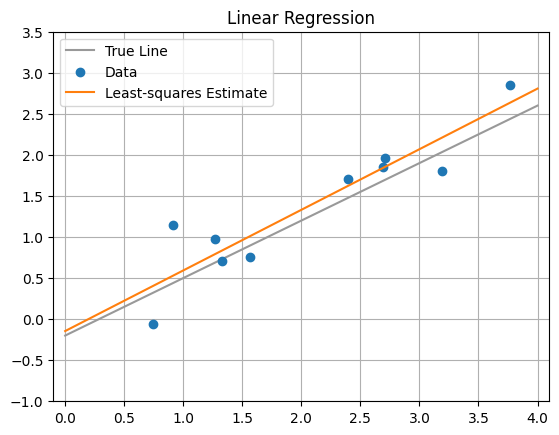

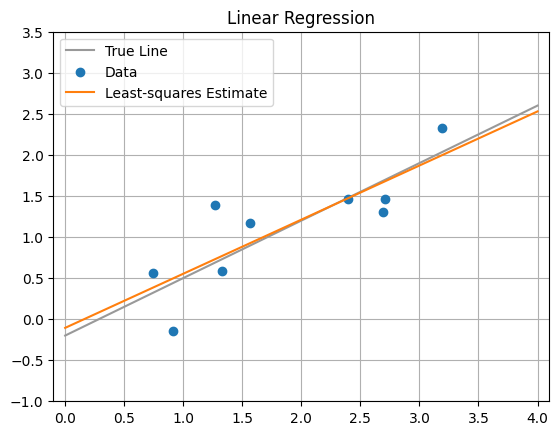

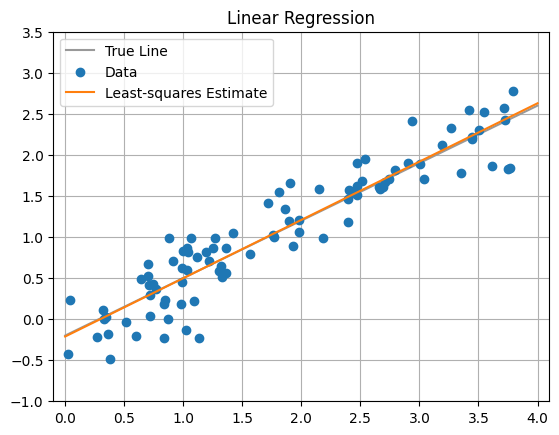

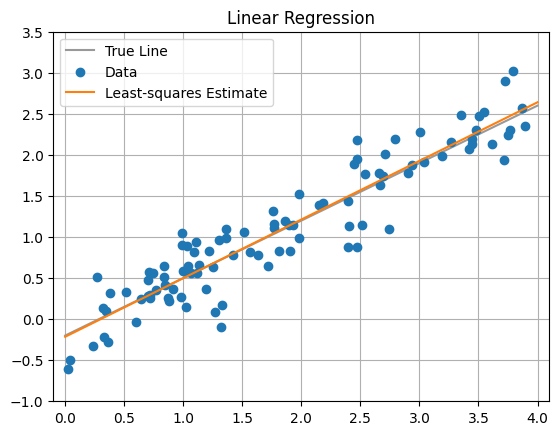

In [ ]:
# PLOT: linear regression
def linreg_plot(n = 10):
    # generate data
    rng = np.random.default_rng(seed=12345)
    X = rng.uniform(low=0, high=4, size=n)
    E = rng.normal(loc=0, scale=0.3, size=n)
    beta = 0.7
    Y = -0.2 + beta * X + E

    # regression
    Z = np.column_stack([np.ones(n), X])
    beta_hat = np.linalg.solve(np.dot(Z.T, Z), np.dot(Z.T, Y))
    #print(beta_hat)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.linspace(0, 4), (-0.2 + beta * np.linspace(0, 4)), c="0.6", zorder=1)
    ax.scatter(X, Y, zorder=2)
    ax.plot(np.linspace(0, 4), (beta_hat[0] + beta_hat[1] * np.linspace(0, 4)), c="C1", zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_xlim([-0.1, 4.1])
    ax.set_ylim([-1, 3.5])
    ax.set_title("Linear Regression")
    ax.legend(["True Line", "Data", "Least-squares Estimate"])
    fig.canvas.draw()

interact(linreg_plot, n=(3, 100));

# Nonlinear Least Squares and Random-Weights Neural Networks.

In this first section, we are going to explore the problem of **nonlinear regression**.

Suppose now, unlike in the case of linear regression, that the relationship in our data is given by
$$ Y_i = f(X_i) + \epsilon_i ,$$
where $f(\cdot)$ is a smooth but otherwise unknown nonlinear function. What can we do here?

A classical statistical approach is to first think of a reasonable *class of functions* to which $f$ may belong. A straightforward guess would be *polynomials*: this is a somewhat basic guess because, if anything, we can think of the Taylor expasion of $f$ take somewhere within the domain of $X_i$. Polynomials are a reasonable first guess!

Let us say that $f(x) = a + b x + c x^2 + d x^3$ for some coefficients $(a, b, c, d) =: \theta$, and that all we have to do is estimate $\theta$. In this case, since after we have applied powers to our regressor $X_i$ the problem is still about recovering linear coefficients, we may use again linear regression:
$$ \widehat{\theta} := \text{arg}\min_{q \in \mathbb{R}^4} \sum_{i=1}^n \big( Y_i - (a + b X_i + c X_i^2 + d X_i^3) \big)^2 $$

Let us look how this goes with a code example:

In [ ]:
# DEFINE: function to generate nonlinear dataset
def generate_nlreg_data(n, range=[0,1], fun=np.sin, var=1, seed=202312):
    rng = np.random.default_rng(seed=seed)
    X = rng.uniform(low=range[0], high=range[1], size=n)
    E = rng.normal(loc=0, scale=var, size=n)
    Y = fun(X) + E
    return({'X': X, 'Y': Y, 'E': E})

In [ ]:
# DEFINE: polynomial regression
def polyreg(Y, X, p=3):
    n = len(Y.squeeze())
    Z = np.ones([n, 1])
    for i in range(1, p):
        Z = np.column_stack([Z, np.power(X, i)])
    theta_hat = np.linalg.solve(np.dot(Z.T, Z), np.dot(Z.T, Y))
    return(theta_hat)

interactive(children=(IntSlider(value=10, description='n', min=3), Output()), _dom_classes=('widget-interact',…

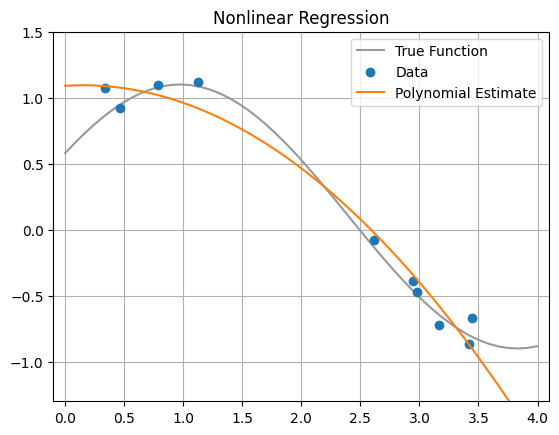

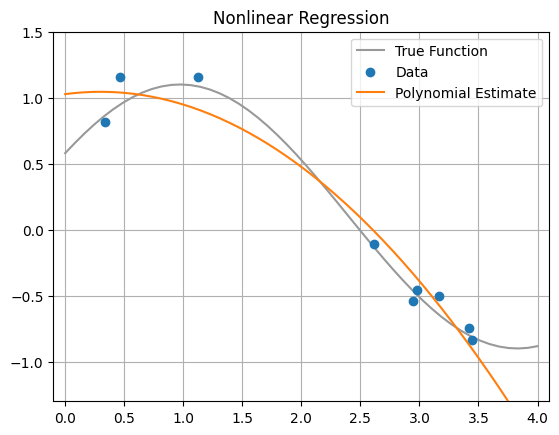

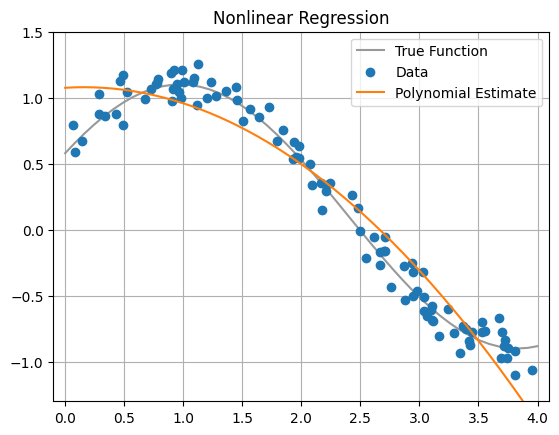

In [ ]:
# PLOT: nonlinear regression data
def data_plot(n = 10):
    # generate data
    X_range = [0, 4]
    def f(x):
        return(np.sin(0.5 + x * 1.1) + 0.1)
    data = generate_nlreg_data(n, fun=f, range=X_range, var=0.1)

    # polynomial regression
    p = 3
    theta_hat = polyreg(data['Y'], data['X'], p=p)
    def polyf_hat(x):
        return(np.dot(np.array([x**i for i in range(0, p)]).T, theta_hat))

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.linspace(*X_range), f(np.linspace(*X_range)), c="0.6", zorder=1)
    ax.scatter(data['X'], data['Y'], zorder=2)
    ax.plot(np.linspace(*X_range), polyf_hat(np.linspace(*X_range)), c="C1", zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_xlim([-0.1, 4.1])
    ax.set_ylim([-1.3, 1.5])
    ax.set_title("Nonlinear Regression")
    ax.legend(["True Function", "Data", "Polynomial Estimate"])
    fig.canvas.draw()

interact(data_plot, n=(3, 100));

If our guess for the form of $f$ was good, we should intuitively see the following:

-  As the number of observations $n$ (the *sample size*) increases, the polynomial estimate (orange) should get close to the true function (gray).

- The error that we make over the interval of $X_i$, the range $[0, 4]$, the error we make should roughly be the same everywhere.

But these things do not seem to happen, even as $n \approx 100$. In fact, we can see that it is "settling" into a quite bad estimate!

# Bad Guesses and Nonlinear Estimation

Turns out (by looking at the code) that our guees is far from the truth. The true function in the above example is a *sinusoid*, which means our polynomial approximation does not do a good job at campturing the underlying relationship between $Y_i$ and $X_i$, even forgoing the fact that noise $\epsilon_i$ is present.

Suppose now, however, that we did not make such a ill-informed guess, but that we had a good theoretical reason to say "The link between $Y$ and $X$ is sinusoidal, we just need to recover the right *frequency* ($\rho$), *shift* ($\tau$) and intercept ($\alpha$)." This is a easier problem now, on the surface, because we know the right "type" of nonlinearity, we just have to find a couple of scalars.

To achieve this, we set up the following problem:
$$ (\widehat{\alpha}, \widehat{\rho}, \widehat{\tau}) := \text{arg}\min_{(a, r, t) \in \mathbb{R}^2} \sum_{i=1}^n \big( Y_i - (a + sin(t + r X_i)) \big)^2 .$$
But now comes the crutch: in our minimization problem, the coefficients $r$ and $t$ are *inside* the nonlinear function. This means that, in general, $\sum_{i=1}^n \big( Y_i - ( \alpha + sin(t + r X_i)) \big)$ is not convex and so we cannot write $\widehat{\alpha}$, $\widehat{\rho}$ and $\widehat{\tau}$ in closed-form. Maybe, numerical optimization might even fail us.

Let us see with a code example:

In [ ]:
# DEFINE: sinusoidal regression
def sinusoidreg(Y, X):
    def sinusoid(x, a, r, t):
        return(a + np.sin(r * x + t))
    theta_hat, _ = opt.curve_fit(sinusoid, X, Y)
    return(theta_hat)

interactive(children=(IntSlider(value=10, description='n', min=3), Output()), _dom_classes=('widget-interact',…

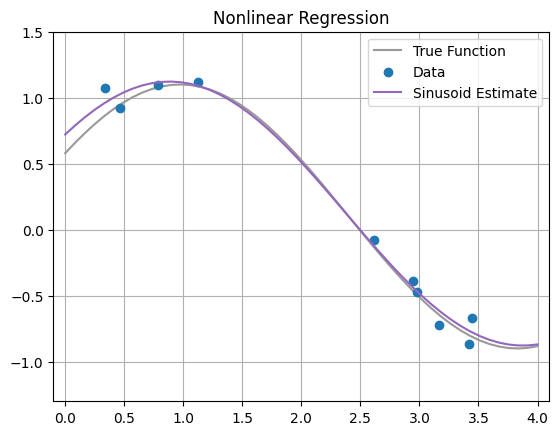

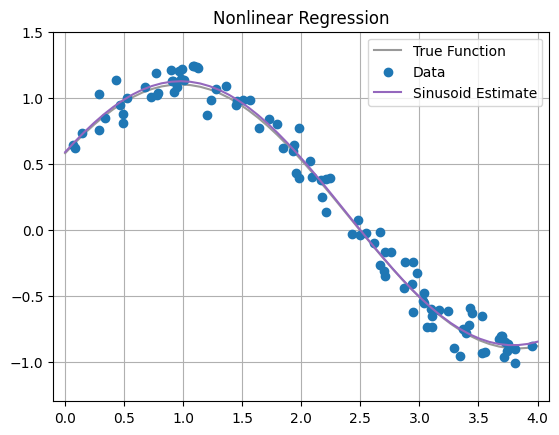

In [ ]:
# PLOT: sinusoid regression
def data_plot(n = 10):
    # generate data
    X_range = [0, 4]
    def f(x):
        return(np.sin(0.5 + x * 1.1) + 0.1)
    data = generate_nlreg_data(n, fun=f, range=X_range, var=0.1)

    # sinusoid regression
    theta_hat = sinusoidreg(data['Y'], data['X'])
    def sinusoid_hat(x):
        return(theta_hat[0] + np.sin(theta_hat[1] * x + theta_hat[2]))

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.linspace(*X_range), f(np.linspace(*X_range)), c="0.6", zorder=1)
    ax.scatter(data['X'], data['Y'], zorder=2)
    ax.plot(np.linspace(*X_range), sinusoid_hat(np.linspace(*X_range)), c="C4", zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_xlim([-0.1, 4.1])
    ax.set_ylim([-1.3, 1.5])
    ax.set_title("Nonlinear Regression")
    ax.legend(["True Function", "Data", "Sinusoid Estimate"])
    fig.canvas.draw()

interact(data_plot, n=(3, 100));

As we can see, the results of our "sinusoidal regression" are much better than those of the polynomial regression we prevously implemented.

But now, we ask, how do we do if we slightly change the true function?

interactive(children=(IntSlider(value=10, description='n', min=3), Output()), _dom_classes=('widget-interact',…

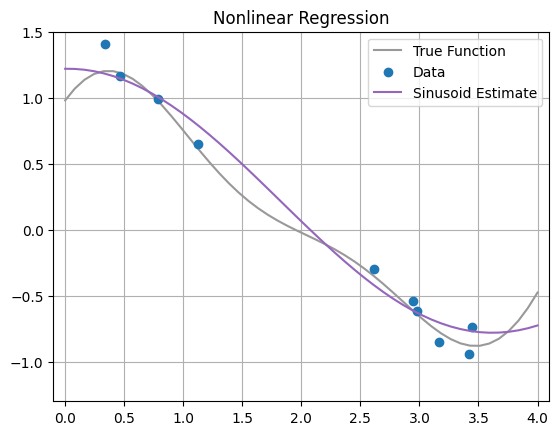

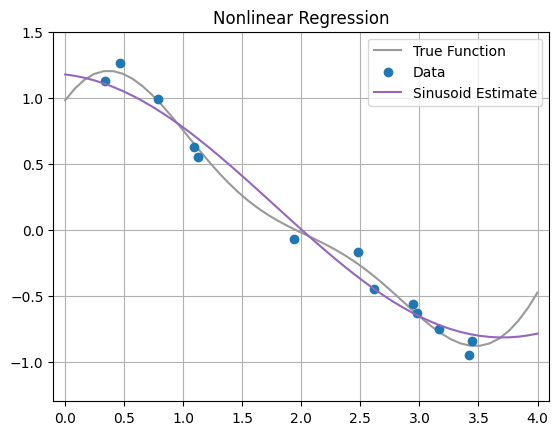

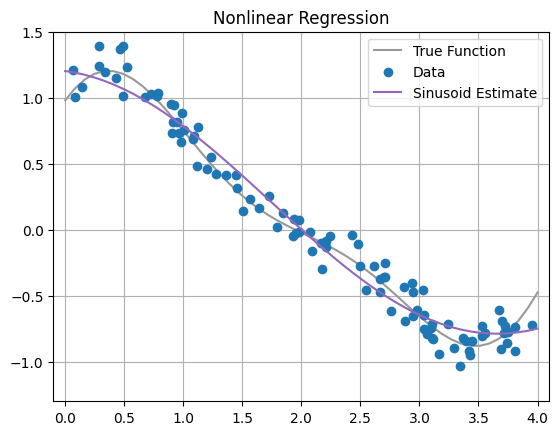

In [ ]:
# PLOT: sinusoid regression
def data_plot(n = 10):
    # generate data
    X_range = [0, 4]
    def f(x):
        return(np.sin(0.5 + x * 1.4) + 0.1 + np.cos(x * 2.4) * 0.4)
    data = generate_nlreg_data(n, fun=f, range=X_range, var=0.1)

    # sinusoid regression
    theta_hat = sinusoidreg(data['Y'], data['X'])
    def sinusoid_hat(x):
        return(theta_hat[0] + np.sin(theta_hat[1] * x + theta_hat[2]))

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.linspace(*X_range), f(np.linspace(*X_range)), c="0.6", zorder=1)
    ax.scatter(data['X'], data['Y'], zorder=2)
    ax.plot(np.linspace(*X_range), sinusoid_hat(np.linspace(*X_range)), c="C4", zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_xlim([-0.1, 4.1])
    ax.set_ylim([-1.3, 1.5])
    ax.set_title("Nonlinear Regression")
    ax.legend(["True Function", "Data", "Sinusoid Estimate"])
    fig.canvas.draw()

interact(data_plot, n=(3, 100));

The true function now is combination of $\sin(\cdot)$ and $\cos(\cdot)$ functions, and, although periodic, it can not be easily approximated by our idea of fitting a $\sin(\cdot)$ with flexible frequency, shift and intercept parameters.

Now we might realize that there are two main paths:

1. We add $\cos(\cdot)$ to our roster of functions to include in the least-squares problem: one just needs to estimate more nonlinear coefficients.

2. Let us consider, instead, *linear combinations of a family of functions* that can approximate well **any function**.

The former option is often expensive and burdensome, but when done with care (in statistics, we often call this setup that of nonlinear *parametric* estimation) can still be very effective.

The latter option is the path that most modern machine learning methods - such as Neural Networks - take (when seen from the appropriate theoretical perspective).

We will now take this second path, and in fact work with a specific class of regression models that select functions *randomly*.

# Random-Weights Neural Networks

RWNN form
$$ h(x; \omega) = \sum_{k=1}^K \omega_j \sigma\left( a_j x + \zeta_j \right) = \omega' \sigma(A \odot x + \zeta) $$

$$ \widehat{\omega} := \text{arg}\min_{w \in \mathbb{R}^K} \sum_{i=1}^n \big( Y_i - h(X_i; w) \big)^2 + \lambda \Vert \omega \Vert_2^2 $$

By letting $Z_i := \sigma(A \odot X_i + \zeta)$ and $Z := (Z_1, \ldots, Z_n) \in \mathbb{R}^n$, we can write down the solution to the previous ridge regression problem in closed for as
$$ \widehat{\omega} = (Z' Z + \lambda I)^{-1} Z' Y. $$
Moreover, the RWNN estimate is given by:
$$ \widehat{h}(x) := \sum_{k=1}^K \widehat{\omega}_j \sigma\left( a_j x + \zeta_j \right)$$

To construct a RWNN, we just need to do the following:

1. Randomly sample coefficients in $A$ and $\zeta$ from an appropriate distribution.
2. Given input feature $X_i$, compute $Z_i := \sigma(A \odot X_i + \zeta)$, the new transformed feature.
3. Perform ridge regression of $Y$ on $Z$.

Below we define function `rwnn()` which implements steps 2 and 3 given data, $A$, $\zeta$ and a ridge penalty.

In [ ]:
# DEFINE: random-weights neural network
def rwnn(Y, X, L, A, zeta, basefun):
    # transform the input features by multiplying with A and adding zeta
    Z = basefun(A * X[:,None] + zeta)
    N, K = Z.shape
    # ridge regression with penalty L
    # NOTE: we adjust here by N, the sample size, so that if we increase
    #       the sample size, the penalization remains comparable
    omega_hat = np.linalg.solve(np.dot(Z.T, Z) + (N*L)*np.eye(K), np.dot(Z.T, Y))
    return(omega_hat)

In the following example, we can take a look at how the RWNN performs as sample size and regularizations changes:

interactive(children=(IntSlider(value=10, description='n', min=3), FloatLogSlider(value=1e-06, description='La…

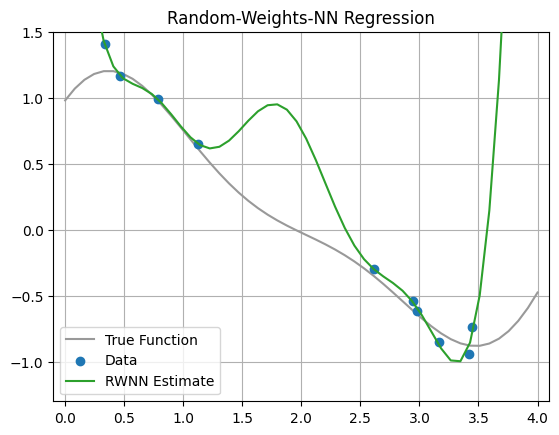

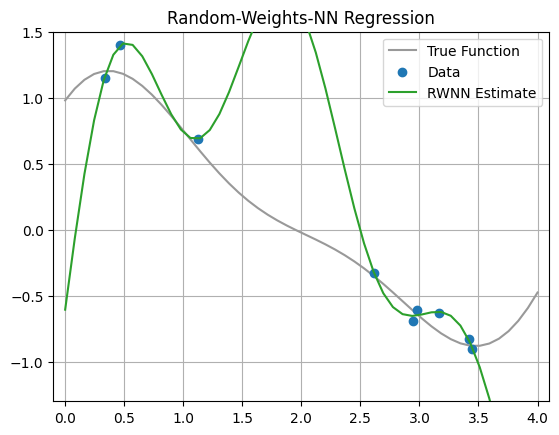

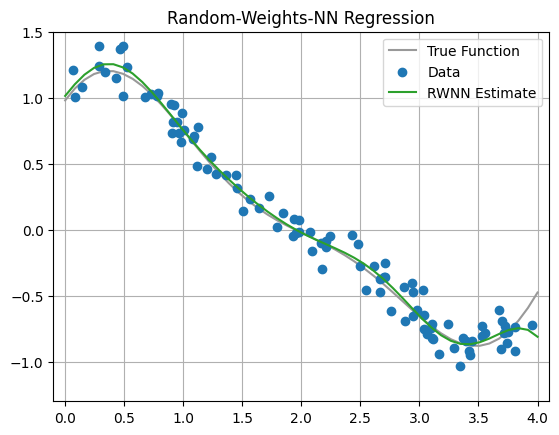

In [ ]:
# PLOT: rwnn regression
def data_plot(n = 10, Lambda = 1e-3):
    # generate data
    X_range = [0, 4]
    def f(x):
        return(np.sin(0.5 + x * 1.4) + 0.1 + np.cos(x * 2.4) * 0.4)
    data = generate_nlreg_data(n, fun=f, range=X_range, var=0.1)

    # random weights
    p = 20
    rng = np.random.default_rng(75871685)
    #A = rng.normal(loc=0, scale=2, size=p)
    A = rng.uniform(low=0, high=4, size=p)
    zeta = rng.uniform(low=0, high=4, size=p)

    # rwnn regression
    omega_hat = rwnn(data['Y'], data['X'], Lambda, A, zeta, np.sin)
    def rwnn_hat(x):
        return(np.dot(np.sin(A * x[:,None] + zeta), omega_hat))

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.linspace(*X_range), f(np.linspace(*X_range)), c="0.6", zorder=1)
    ax.scatter(data['X'], data['Y'], zorder=2)
    ax.plot(np.linspace(*X_range), rwnn_hat(np.linspace(*X_range)), c="C2", zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_xlim([-0.1, 4.1])
    ax.set_ylim([-1.3, 1.5])
    ax.set_title("Random-Weights-NN Regression")
    ax.legend(["True Function", "Data", "RWNN Estimate"])
    fig.canvas.draw()

interact(data_plot, n=(3, 100), Lambda=widgets.FloatLogSlider(min=-8, max=2, value=1e-6));

To better inspect the RWNN method, let us take a look "under the hood" and plot the functions that are being applied to $X$ when constructing the new features in $Z$:

interactive(children=(IntSlider(value=5, description='p', max=50, min=3), FloatSlider(value=0.0, description='…

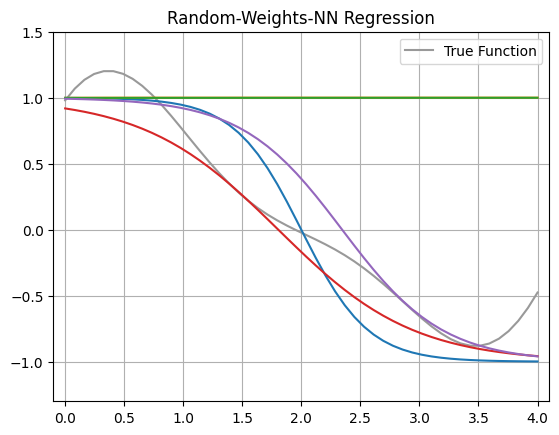

In [ ]:
# PLOT: rwnn regression
def data_plot(p = 5, A_mean = 0, A_var = 1, zeta_range=[0., 4.]):
    # generate data
    X_range = [0, 4]
    def f(x):
        return(np.sin(0.5 + x * 1.4) + 0.1 + np.cos(x * 2.4) * 0.4)

    # random weights
    rng = np.random.default_rng(75871685)
    A = rng.normal(loc=A_mean, scale=A_var, size=p)
    zeta = rng.uniform(low=zeta_range[0], high=zeta_range[1], size=p)

    # rwnn regression
    def rwnn_featuremap(x, i):
        return(np.tanh(A[i] * x[:,None] + zeta[i]))

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.linspace(*X_range), f(np.linspace(*X_range)), c="0.6", zorder=1)
    for i in range(p):
        ax.plot(np.linspace(*X_range), rwnn_featuremap(np.linspace(*X_range), i), zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_xlim([-0.1, 4.1])
    ax.set_ylim([-1.3, 1.5])
    ax.set_title("Random-Weights-NN Regression")
    ax.legend(["True Function"])
    fig.canvas.draw()

interact(data_plot, p=(3, 50), A_mean=(-10.0, 10.0), A_var=(0.01, 3),
            zeta_range=widgets.FloatRangeSlider(value=[0, 4], min=-10.0, max=10.0));

Since both $A$ and $\zeta$ are random, what happens when we *resample* from their respective distribution and contruct a new RWNN estimate?

In the following plot, we do not contruct only one RWNN estimate, but instead use a number $p$ of different models. We can then plot both the *mean* estimate (green line) and the 95% frequency band (light green), which tells us how "dispersed" are the different RWNN estimates.

interactive(children=(IntSlider(value=10, description='n', min=3), FloatLogSlider(value=1e-06, description='La…

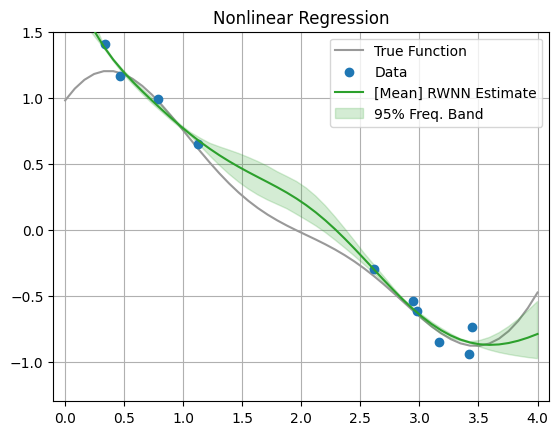

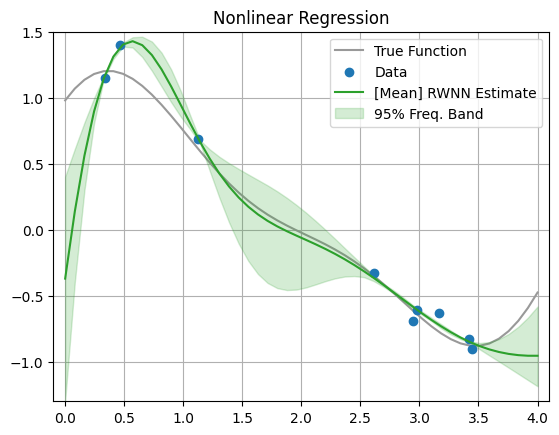

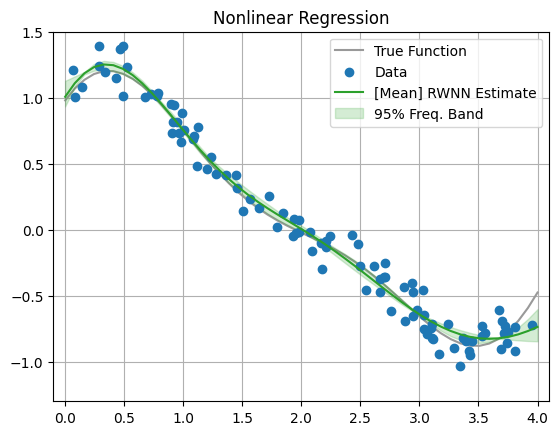

In [ ]:
# PLOT: rwnn redrawing
def data_plot(n = 10, Lambda = 1e-3, p = 10, draws = 5):
    # generate data
    X_range = [0, 4]
    def f(x):
        return(np.sin(0.5 + x * 1.4) + 0.1 + np.cos(x * 2.4) * 0.4)
    data = generate_nlreg_data(n, fun=f, range=X_range, var=0.1)

    X_linsp = np.linspace(*X_range)

    # rwnn
    def rwnn_hat(x, A_, zeta_, omega_):
        return(np.dot(np.tanh(A_ * x[:,None] + zeta_), omega_))

    # redraw and fit
    rng = np.random.default_rng(75871685)

    fits = np.zeros([draws, len(X_linsp)])
    for b in range(draws):
        # random weights
        A_ = rng.normal(loc=0, scale=1, size=p)
        zeta_ = rng.uniform(low=0, high=4, size=p)

        # rwnn regression
        omega_hat = rwnn(data['Y'], data['X'], Lambda, A_, zeta_, np.tanh)
        fits[b,:] = rwnn_hat(X_linsp, A_, zeta_, omega_hat)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(X_linsp, f(X_linsp), c="0.6", zorder=1)
    ax.scatter(data['X'], data['Y'], zorder=2)
    ax.plot(X_linsp, np.mean(fits, axis=0), c="C2", zorder=3)
    ax.fill_between(X_linsp, *np.quantile(fits, [0.05, 0.95], axis=0), color="C2", alpha=0.2)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_xlim([-0.1, 4.1])
    ax.set_ylim([-1.3, 1.5])
    ax.set_title("Nonlinear Regression")
    ax.legend(["True Function", "Data", "[Mean] RWNN Estimate", "95% Freq. Band"])
    fig.canvas.draw()

interact(data_plot, n=(3, 100), Lambda=widgets.FloatLogSlider(min=-8, max=2, value=1e-6),
            p=(3,100), draws=(1,50));

# Echo State Networks

In this section, we are going to move out attention to the problem of modeling (and estimating) **dynamic** nonlinear models, such as the one defined by nonlinear time series or different equations.

The tool we are going to discuss is the so call **Echo State Network (ESN)**, which in a nutshell is a class of nonlinear models with a state-space structure that is constructed entirely out of random functions - a bit like in the RWNN setup we just discussed.

## Constructing Echo State Networks

ESNs are constructed starting from the following general model equations:
$$ \begin{align}
x_t & = H(x_{t-1}, z_t), \\
y_t & = F(x_t),
\end{align}
$$
where here we use $x_t \in \mathbb{R}^{d_x}$, $y_t \in \mathbb{R}^{d_y}$ and $z_t \in \mathbb{R}^{d_z}$ to signify time series that do not necessarily need to be noisy. The sequence $\{ z_t \}_{t=1}^T$ is called the **inputs**, while sequence $\{ y_t \}_{t=1}^T$ is called the **targets** of the model.

An ESN proposes a specific form for (1)-(2), namely
$$ \begin{align}
x_t & = \alpha x_{t-1} + (1 -\alpha)\sigma(A x_{t-1} + C z_t + \zeta), \\
y_t & = W x_t,
\end{align}
$$
where $A \in \mathbb{R}^{d_x \times d_x}$, $C \in \mathbb{R}^{d_x \times d_z}$ and $\zeta \in \mathbb{R}^{d_x}$ are *randomly drawn matrices/vectors*; $\alpha \in [0,1]$ is the so-called *leak-rate*, and $W \in \mathbb{R}^{d_y \times d_x}$ are the coefficients of the model that are actually estimated from data.

SN models has show to be effective in reconstructing even complex systems and dynamics, and their expressive power is coupled with an increadible easy of implementation. Since all of the ESN parameters in equation (1) do not need estimation, we can generally proceed as follows:

1. Randomly draw $A$, $C$ and $\zeta$ from a chosen distribution, select $\alpha$.
2. Given inputs $\{ z_t \}_{t=1}^T$, *collect* the ESN states $\{ x_t \}_{t=1}^T$ by fixing an initial state $x_0$ and iterating

    $$x_t = \alpha x_{t-1} + (1 -\alpha)\sigma(A x_{t-1} + C z_t + \zeta)$$
3. Construct target matrix $Y := (y_1', \ldots, y_T')' \in \mathbb{R}^{T \times d_y}$ and state matrix $X := (x_1, \ldots, x_T)\in \mathbb{R}^{T \times d_x}$.
4. Use ridge regression with penalty $\lambda \geq 0$ to estimate

    $$\widehat{W} := (Z' Z + \lambda I)^{-1} Z'Y$$

Let us write this in code:

In [ ]:
# DEFINE: state collection
def esn_collect(Z, A, C, zeta, alpha):
    T = Z.shape[0]
    Dx = A.shape[0]
    # NOTE: we are going to assume that x_0 == 0 for simplicity
    #       and that the nonlinear map \sigma(.) is tanh(.)
    X = np.zeros([T, Dx])
    X[0,:] = (1-alpha) * np.tanh(C @ Z[1,:] + zeta)
    for t in range(1,T):
        X[t,:] = alpha * X[t-1,:] + (1-alpha) * np.tanh(A @ X[t-1,:] + C @ Z[t,:] + zeta)
    return(X)

In [ ]:
# DEFINE: esn fitting
def esn_fit(Y, Z, L, A, C, zeta, alpha):
    # collect states
    X = esn_collect(Z, A, C, zeta, alpha)
     # ridge regression with penalty L
    # NOTE: we adjust here by T, the time length, so that if we increase
    #       the sample size, the penalization remains comparable
    T, K = X.shape
    W_hat = np.linalg.solve(np.dot(X.T, X) + (T*L)*np.eye(K), np.dot(X.T, Y))
    # compute fitted values and fit error
    Y_fit = X @ W_hat
    Error = Y - Y_fit
    return (W_hat, X, Y_fit, Error)

We can now try and fit an nonlinear deterministic sequence using the ESN model. For this example, let us consider a simple but not totally trivial model where
$$\begin{align}
z_t & = sin(t) , \\
y_t & = -0.3 + z_t + z_t^2 + 0.3\, cos(3 z_t - 3) .
\end{align}
$$

In the following code, we randomly sample the entried in the parameter matrices $A$ and $C$ from a standard normal distribution, while $\zeta$ has entries from a uniform distribution over $[-1,1]$.
We are also able to tweak the ridge penalty, $\lambda$ (slider `Lambda`), and see how this affects the fit of the model.

interactive(children=(IntSlider(value=100, description='T', max=500, min=1), IntSlider(value=10, description='…

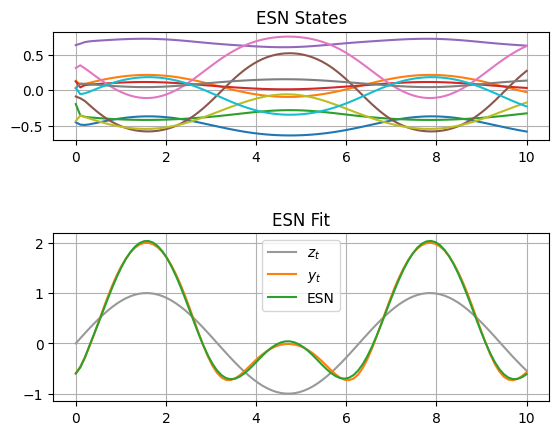

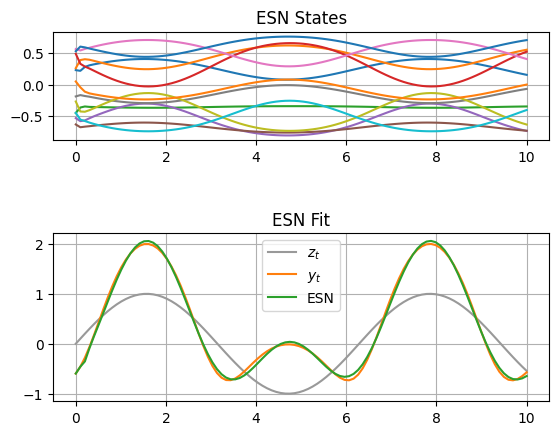

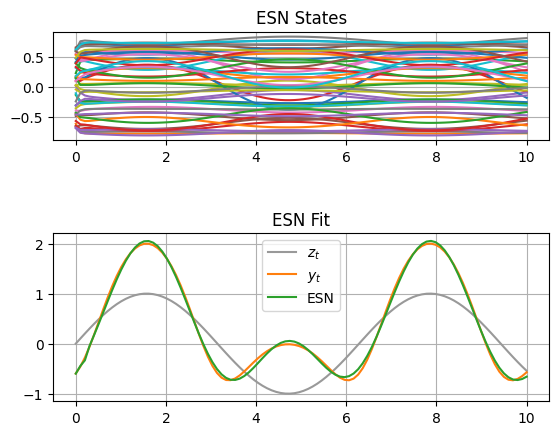

In [ ]:
def esn_plot(T = 100, Dx = 10, rho = 0.5, gamma = 1, alpha = 0.1, Lambda = 1e-7):
    # generate data
    time = np.linspace(0, T*0.1, T)
    #print(time)
    Z = np.sin(time)[:,None]
    Y = Z + Z**2 - 0.3 + 0.3*np.cos(3*(Z - 1))

    # generate ESN parameters
    rng = np.random.default_rng(75871685)
    A = rng.normal(loc=0, scale=1, size=[Dx, Dx])
    C = rng.normal(loc=0, scale=1, size=[Dx, 1])
    zeta = rng.uniform(low=-1, high=1, size=Dx)

    # normalize
    A = (A / np.linalg.norm(A, 2)) * rho
    C = (C / np.linalg.norm(C, 2)) * gamma

    # fit esn
    _, X, Y_fit, _ = esn_fit(Y, Z, Lambda, A, C, zeta, alpha)

    fig = plt.figure()
    ax = fig.add_subplot(3, 1, 1)
    ax.plot(time, X)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_title("ESN States")

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(time, Z, c="0.6", zorder=1)
    ax.plot(time, Y, c="C1", zorder=2)
    ax.plot(time, Y_fit, c="C2", zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_title("ESN Fit")
    ax.legend(["$z_t$", "$y_t$", "ESN"])
    fig.canvas.draw()

interact(esn_plot, T=(1, 500), Dx=(5,50), rho=(0.1, 1.1), gamma=(0.1,3), alpha=(0.,1.),
            Lambda=widgets.FloatLogSlider(min=-8, max=2, value=1e-6));

Notice that, as we increase the dimension of state vector $x_t$ (changing slider `Dx`), we can see that the fit impoves to the point where it is hard to distinguish it from the true values of $y_t$.

## Autonomous ESN Models

One drawback from the previous ESN example is that often we do not only want to *fit* the data, but we would also like to *reconstruct the underlying dynamics*. That is, we would like the ESN to not only perfom well at a one-shot (one-step) forecasting task, but be able to reproduce the time series of interest directly.
We can ask this of the ESN model because it is state-space-based and, therefore, if we can iterate the states *autonomously* then we should also recover the true data-generating process.

The theory of ESNs fortunately guarantees that (in an appropriate sense) if the state space that $x_t$ belongs to is sufficiently big, then we will be reconstructing the underlying dynamics correctly. From a theory point of view, this is a very important result. And from the applied point of view, it is actually something we can easily implement.

Recall the ESN equations
$$ \begin{align}
x_t & = \alpha x_{t-1} + (1 -\alpha)\sigma(A x_{t-1} + C z_t + \zeta), \\
y_t & = W x_t,
\end{align}
$$
and suppose now that we let $y_t = z_{t+1}$. That is, we impose a prective structure on our ESN model. This means that $y_{t-1} = z_t$.

Now, plug in equation (2) shifted to time $t-1$ - that is, $z_t = y_{t-1} = W x_{t-1}$ - into (1), and we obtain
$$ \begin{align*}
x_t & = \alpha x_{t-1} + (1 -\alpha)\sigma(A x_{t-1} + C z_t + \zeta) \\
    & = \alpha x_{t-1} + (1 -\alpha)\sigma(A x_{t-1} + C W x_{t-1} + \zeta) \\
    & = \alpha x_{t-1} + (1 -\alpha)\sigma\left((A + C W) x_{t-1} + \zeta\right) .
\end{align*}
$$
Notice that the last line provides a recursion of the form $x_t = G(x_{t-1})$, where is $G(\cdot)$ is parametrized by $(A, C, \zeta, \alpha, W)$ and map $\sigma(\cdot)$. With this recursive formulation, which is often called the **autonomous** form of the ESN, we can predict $y_t$ (thus, $z_t$) at any future horizon, potentially:
$$ \begin{align*}
x_{t+h} & = G^h (x_t) =  \underbrace{G \circ G \circ \cdots \circ G}_{h \text{ times}}\,(x_t) \\
y_{t+h} & = W x_{t+h},
\end{align*}
$$
for any $h \geq 1$.

Let us implement the autonomous ESN iteration:

In [ ]:
# DEFINE: autonomous iteration
def esn_auto(X0, h, A, C, zeta, alpha, W):
    Dx = A.shape[0]
    Dy = W.shape[1]
    # pre-compute autonomous matrix
    R = A + C @ W.T
    # NOTE: we are going to assume that x_0 == 0 for simplicity
    #       and that the nonlinear map \sigma(.) is tanh(.)
    Xh = np.zeros([h, Dx])
    Yh = np.zeros([h, Dy])
    Xh[0,:] = X0
    Yh[0,:] = X0 @ W
    for t in range(1,h):
        Xh[t,:] = alpha * Xh[t-1,:] + (1-alpha) * np.tanh(R @ Xh[t-1,:] + zeta)
        Yh[t,:] = Xh[t,:] @ W
    return(Xh, Yh)

Considering again the deterministic time series model from the previous section, we now try and (1) fit process $\{y_t\}$ *directly* (i.e. it is both inputs and outputs); (2) forecast autonomously:

interactive(children=(IntSlider(value=100, description='T', max=500, min=1), IntSlider(value=20, description='…

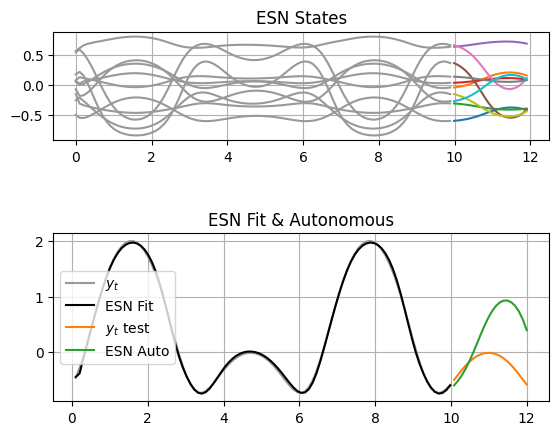

In [ ]:
def esn_plot(T = 100, h = 20, Dx = 10, rho = 0.5, gamma = 1, alpha = 0.1, Lambda = 1e-7):
    # generate data
    time = np.linspace(0, (T+h)*0.1, T+h)
    #print(time)
    Z = np.sin(time)[:,None]
    Y = Z + Z**2 - 0.3 + 0.3*np.cos(3*(Z - 1))

    # split train and test
    Y_train_in = Y[:T-1,:]
    Y_train_out = Y[1:T,:]
    Y_test = Y[T:,:]

    # generate ESN parameters
    rng = np.random.default_rng(75871685)
    A = rng.normal(loc=0, scale=1, size=[Dx, Dx])
    C = rng.normal(loc=0, scale=1, size=[Dx, 1])
    zeta = rng.uniform(low=-1, high=1, size=Dx)

    # normalize
    A = (A / np.linalg.norm(A, 2)) * rho
    C = (C / np.linalg.norm(C, 2)) * gamma

    # fit esn
    W_hat, X, Y_fit, _ = esn_fit(Y_train_out, Y_train_in, Lambda, A, C, zeta, alpha)

    # autonomous esn
    Xh, Yh = esn_auto(X[-1,:], h, A, C, zeta, alpha, W_hat)

    fig = plt.figure()
    ax = fig.add_subplot(3, 1, 1)
    ax.plot(time[0:T-1], X, c="0.6")
    ax.plot(time[T-1:-1], Xh)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_title("ESN States")

    ax = fig.add_subplot(2, 1, 2)
    #ax.plot(time[0:T-1], Y_train_in, c="0.6", zorder=1)
    ax.plot(time[1:T], Y_train_out, c="0.6", zorder=2)
    ax.plot(time[1:T], Y_fit, c="k", zorder=3)
    ax.plot(time[T:], Y_test, c="C1", zorder=2)
    ax.plot(time[T:], Yh, c="C2", zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_title("ESN Fit & Autonomous")
    ax.legend(["$y_t$", "ESN Fit", "$y_t$ test", "ESN Auto"], loc="center left")
    fig.canvas.draw()

interact(esn_plot, T=(1, 500), h=(1, 100), Dx=(5,50), rho=(0.1, 1.1), gamma=(0.1,3), alpha=(0.,1.),
            Lambda=widgets.FloatLogSlider(min=-8, max=2, value=1e-6));

## Predicting Chaotic Systems

ESNs have been widely applied to to prediction of nonlinear dynamical systems -- an area where they have been shown to be extremely effective. In this section, we will consider two cases

1. Autonomous ESN prediction of an ODE system - the *Lorenz attractor*.
2. Autonomous ESN prediction of a time-delay system - the *Mackey-Glass equations*.

The **Lorenz attractor** is a well-known three-dimensional system that exhibits caotic behavior. Its equations are:
$$\begin{align}
\frac{d x}{d t} & = \sigma(y - x) , \\
\frac{d y}{d t} & = x(\rho - z) - y , \\
\frac{d z}{d t} & = x y - \beta z .
\end{align}
$$

The following code provides a simple implementation of the Lorenz equations (with a plot):

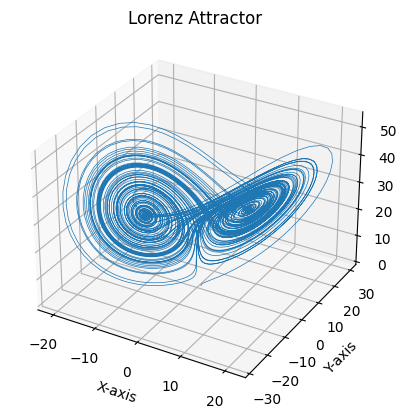

In [ ]:
# DEFINE: Lorenz attractor
def lorenz_attractor(sigma, rho, beta, initial_state, delta_t, num_steps):
    """
    Simulate the Lorenz attractor.

    Parameters:
        sigma (float): Parameter sigma
        rho (float): Parameter rho
        beta (float): Parameter beta
        initial_state (tuple): Initial state (x0, y0, z0)
        num_steps (int): Number of simulation steps

    Returns:
        Tuple of NumPy arrays (x, y, z) representing the simulated trajectory.
    """
    x, y, z = initial_state
    x_vals, y_vals, z_vals = [x], [y], [z]

    for _ in range(num_steps):
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z

        x += delta_t * dx
        y += delta_t * dy
        z += delta_t * dz

        x_vals.append(x)
        y_vals.append(y)
        z_vals.append(z)

    return np.array(x_vals), np.array(y_vals), np.array(z_vals)

# Set the parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
initial_state = (1.0, 0.0, 0.0)

# Simulate the Lorenz attractor
x, y, z = lorenz_attractor(sigma, rho, beta, initial_state, 0.01, 10000)

# Plot the 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Lorenz Attractor')

plt.show()

Let us now try to autonomously predict the $y$ component of the Lorenz equations with an ESN:

interactive(children=(IntSlider(value=1500, description='steps', max=2500, min=500), IntSlider(value=500, desc…

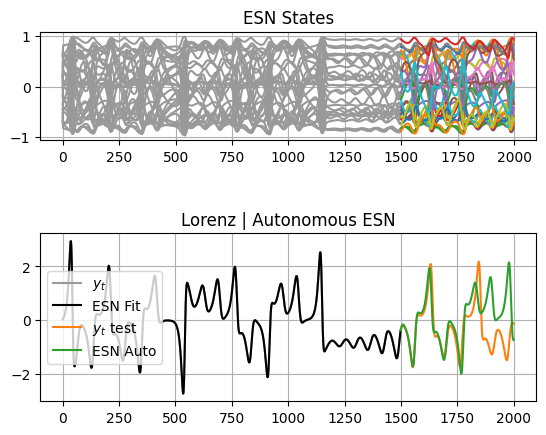

In [ ]:
def esn_lorenz(steps = 1500, h = 500, Dx = 30, rho = 0.7, gamma = 1, alpha = 0.1, Lambda = 1e-9):
    # generate data (rescaled by 0.1x)
    data_x, data_y, data_z = lorenz_attractor(10.0, 28.0, 8.0/3, (1.0, 0.0, 0.0), 0.01, steps + h)
    data = np.column_stack([data_x, data_y, data_z]) / 10.0

    # split train and test
    Y_train_in = data[:steps-1,:]
    Y_train_out = data[1:steps,:]
    Y_test = data[steps:,:]

    # generate ESN parameters
    rng = np.random.default_rng(75871685)
    A = rng.normal(loc=0, scale=1, size=[Dx, Dx])
    C = rng.normal(loc=0, scale=1, size=[Dx, 3])
    zeta = rng.uniform(low=-1, high=1, size=Dx)

    # normalize
    A = (A / np.linalg.norm(A, 2)) * rho
    C = (C / np.linalg.norm(C, 2)) * gamma

    # fit esn
    W_hat, X, Y_fit, _ = esn_fit(Y_train_out, Y_train_in, Lambda, A, C, zeta, alpha)

    # autonomous esn
    Xh, Yh = esn_auto(X[-1,:], h, A, C, zeta, alpha, W_hat)

    fig = plt.figure()
    ax = fig.add_subplot(3, 1, 1)
    ax.plot(range(0, steps-1), X, c="0.6")
    ax.plot(range(steps-1, steps-1+h), Xh)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_title("ESN States")

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(range(1, steps), Y_train_out[:,1], c="0.6", zorder=2)
    ax.plot(range(1, steps), Y_fit[:,1], c="k", zorder=3)
    ax.plot(range(steps, steps+h+1), Y_test[:,1], c="C1", zorder=2)
    ax.plot(range(steps, steps+h), Yh[:,1], c="C2", zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_title("Lorenz | Autonomous ESN")
    ax.legend(["$y_t$", "ESN Fit", "$y_t$ test", "ESN Auto"], loc="center left")
    fig.canvas.draw()

interact(esn_lorenz, steps=(500, 2500), h=(100, 1000), Dx=(5,50), rho=(0.1, 1.5), gamma=(0.1,3), alpha=(0.,1.),
            Lambda=widgets.FloatLogSlider(min=-9, max=2, value=1e-7));

Next, we try to forecast a more complex model. The Mackey-Glass equations are time-delay differency equations are such that the time derivative depends not only on the current value, but also on lagged values of the model.

We will consider the following Mackey-Glass model:
$$ \frac{d x(t)}{d t} = \frac{\beta x(t - \tau)}{1 + x(t - \tau)^n} - \gamma x(t) ,$$
where here the solution $x(t)$ is indexed by time explicitly to properly define delayed value $x(t - \tau)$. We are going to conside the original cofficients employed in the original paper, $\beta = 0.2$, $n = 10$ and $\gamma = 0.1$, and initial condition $x(0) = 0.5$.

The following function solves the Mackey-Glass model (plotting an example solution):

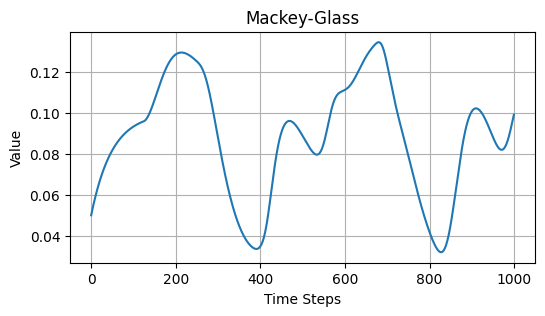

In [ ]:
# DEFINE: mackey-glass equations
def mackey_glass(beta, gamma, n, tau, a, delta_t, num_steps):
    """
    Simulate the Mackey-Glass equations.

    Parameters:
        beta (float): Parameter beta
        gamma (float): Parameter gamma
        n (float): Parameter n
        tau (float): Time delay parameter
        a (float): Amplitude parameter
        delta_t (float): Time step size
        num_steps (int): Number of simulation steps

    Returns:
        NumPy array representing the simulated trajectory.
    """
    x = np.zeros(num_steps)
    x[0] = 0.5  # Initial condition

    for t in range(1, num_steps):
        delay_index = max(t - int(tau / delta_t), 0)
        x[t] = x[t - 1] + delta_t * (beta * x[delay_index] / (1.0 + x[delay_index]**n) - gamma * x[t - 1])

    return a * x

# Simulate the Mackey-Glass equations
num_steps = 1000
trajectory = mackey_glass(0.2, 0.1, 10, 25, 0.1, 0.2, num_steps)

# Plot the simulated trajectory
plt.figure(figsize=(6,3))
plt.plot(trajectory)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Mackey-Glass')
plt.grid()
plt.show()


We can again try and iterate forward the Mackey-Glass solution by using an ESN autonomously:

interactive(children=(IntSlider(value=1500, description='steps', max=2500, min=500), IntSlider(value=400, desc…

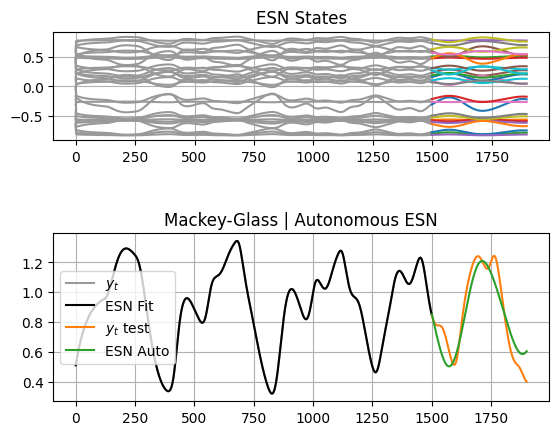

In [ ]:
def esn_mackeyglass(steps = 1500, h = 400, Dx = 30, rho = 0.7, gamma = 1, alpha = 0.1, Lambda = 1e-9):
    # generate data (rescaled by 10x)
    data = mackey_glass(0.2, 0.1, 10, 25, 0.1, 0.2, steps + h)[:,None] * 10.0

    # split train and test
    Y_train_in = data[:steps-1,:]
    Y_train_out = data[1:steps,:]
    Y_test = data[steps:,:]

    # generate ESN parameters
    rng = np.random.default_rng(75871685)
    A = rng.normal(loc=0, scale=1, size=[Dx, Dx])
    C = rng.normal(loc=0, scale=1, size=[Dx, 1])
    zeta = rng.uniform(low=-1, high=1, size=Dx)

    # normalize
    A = (A / np.linalg.norm(A, 2)) * rho
    C = (C / np.linalg.norm(C, 2)) * gamma

    # fit esn
    W_hat, X, Y_fit, _ = esn_fit(Y_train_out, Y_train_in, Lambda, A, C, zeta, alpha)

    # autonomous esn
    Xh, Yh = esn_auto(X[-1,:], h, A, C, zeta, alpha, W_hat)

    fig = plt.figure()
    ax = fig.add_subplot(3, 1, 1)
    ax.plot(range(0, steps-1), X, c="0.6")
    ax.plot(range(steps-1, steps-1+h), Xh)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_title("ESN States")

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(range(1, steps), Y_train_out, c="0.6", zorder=2)
    ax.plot(range(1, steps), Y_fit, c="k", zorder=3)
    ax.plot(range(steps, steps+h), Y_test, c="C1", zorder=2)
    ax.plot(range(steps, steps+h), Yh, c="C2", zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_title("Mackey-Glass | Autonomous ESN")
    ax.legend(["$y_t$", "ESN Fit", "$y_t$ test", "ESN Auto"], loc="center left")
    fig.canvas.draw()

interact(esn_mackeyglass, steps=(500, 2500), h=(100, 1000), Dx=(5,50), rho=(0.1, 1.5), gamma=(0.1,10), alpha=(0.,1.),
            Lambda=widgets.FloatLogSlider(min=-9, max=2, value=1e-9));

## Nonlinear Time Series

We now move from the deterministic setting to a stochastic one. In particular, we will try to forecast a simple nonlinear autoregressive time series model with an ESN model.

Let $\{\epsilon_t\}_{t \in \mathbb{Z}}$ be a sequence of independent random variables identically uniformly distributed over the interval $[-1, 1]$, and define
$$ X_t = \frac{2 X_{t-1}}{1 + 0.8\, X_{t-1}^2} + \epsilon_t .$$

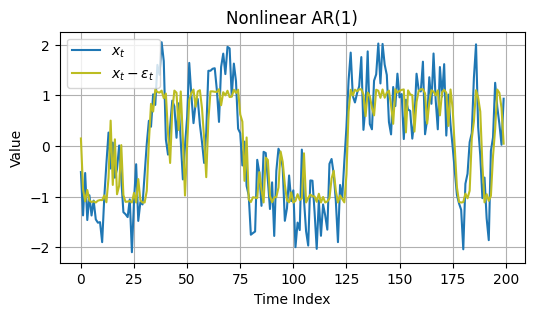

In [ ]:
# DEFINE: nonlinear time series
def nonlin_ar(n, init=100, seed=12345):
    rng = np.random.default_rng(seed)
    E = np.zeros(n+init)
    X = np.zeros(n+init)
    E[0] = rng.uniform(low=-1, high=1)
    for t in range(1, n+init):
        E[t] = rng.uniform(low=-1, high=1)
        X[t] = 2 * X[t-1] / (1 + 0.8*X[t-1]**2) + E[t]
    return(X[init:], E[init:])

# Generate data
X_t, E_t = nonlin_ar(200)

# Plot the simulated trajectory
plt.figure(figsize=(6,3))
plt.plot(X_t)
plt.plot(X_t - E_t, c="C8")
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.title('Nonlinear AR(1)')
plt.legend(["$x_t$", "$x_t - \epsilon_t$"], loc="upper left")
plt.grid()
plt.show()

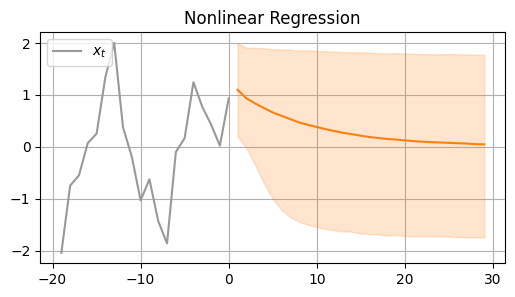

In [ ]:
def nonlin_ar_condpred(h, X0, mc=1000, seed=54321):
    rng = np.random.default_rng(seed)
    Xh = np.zeros([h, mc])
    Xh[0,:] = X0
    for t in range(1, h):
        # randomly sample innovations
        E = rng.uniform(low=-1, high=1, size=mc)
        Xh[t,:] = 2 * Xh[t-1,:] / (1 + 0.8*Xh[t-1,:]**2) + E
    return(Xh)

# Simulate best conditional predictor
h = 30
condpred = nonlin_ar_condpred(h, X_t[-1], mc=50000)

# Plot (with prediction bands)
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(-19, 1), X_t[-20:], c="0.6", zorder=1)
ax.plot(range(1, h), np.mean(condpred[1:,], axis=1), c="C1", zorder=3)
ax.fill_between(range(1, h), *np.quantile(condpred[1:,], [0.05, 0.95], axis=1), color="C1", alpha=0.2)
ax.set_axisbelow(True)
ax.grid()
ax.set_title("Nonlinear Regression")
ax.legend(["$x_t$"], loc="upper left")
fig.canvas.draw()

interactive(children=(IntSlider(value=200, description='steps', max=500, min=50), IntSlider(value=30, descript…

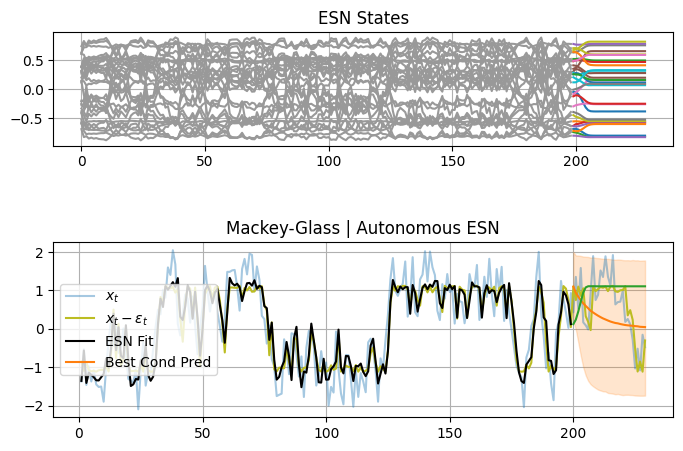

In [ ]:
def esn_nonlinear_ar(steps = 200, h = 30, Dx = 30, rho = 0.7, gamma = 1, theta = 1, alpha = 0.1, Lambda = 1e-6):
    # generate data (rescaled by 10x)
    X_t, E_t = nonlin_ar(steps+h)
    data = X_t[:,None]

    # split train and test
    X_t_train_in = data[:steps-1,:]
    X_t_train_out = data[1:steps,:]
    #X_t_test = data[steps:,:]

    # generate ESN parameters
    rng = np.random.default_rng(75871685)
    A = rng.normal(loc=0, scale=1, size=[Dx, Dx])
    C = rng.normal(loc=0, scale=1, size=[Dx, 1])
    zeta = rng.uniform(low=-1, high=1, size=Dx)

    # normalize
    A = (A / np.linalg.norm(A, 2)) * rho
    C = (C / np.linalg.norm(C, 2)) * gamma
    zeta = theta * zeta

    # fit esn
    W_hat, states, X_t_fit, _ = esn_fit(X_t_train_out, X_t_train_in, Lambda, A, C, zeta, alpha)

    # autonomous esn
    Xh, Yh = esn_auto(states[-1,:], h, A, C, zeta, alpha, W_hat)

    # best conditional predictor
    condpred = nonlin_ar_condpred(h+1, X_t_train_out[-1,:], mc=50000)

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(3, 1, 1)
    ax.plot(range(0, steps-1), states, c="0.6")
    ax.plot(range(steps-1, steps-1+h), Xh)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_title("ESN States")

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(range(1, steps+h), X_t[1:,], c="C0", alpha=0.4, zorder=2)
    ax.plot(range(1, steps+h), X_t[1:,] - E_t[1:], c="C8", zorder=2)
    ax.plot(range(1, steps), X_t_fit, c="k", zorder=3)
    ax.plot(range(steps, steps+h), np.mean(condpred[1:,], axis=1), c="C1", zorder=3)
    ax.fill_between(range(steps, steps+h), *np.quantile(condpred[1:,], [0.05, 0.95], axis=1), color="C1", alpha=0.2)
    ax.plot(range(steps, steps+h), Yh, c="C2", zorder=3)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_title("Mackey-Glass | Autonomous ESN")
    ax.legend(["$x_t$", "$x_t - \epsilon_t$", "ESN Fit", "Best Cond Pred"], loc="center left")
    fig.canvas.draw()

interact(esn_nonlinear_ar, steps=(50, 500), h=(3, 100), Dx=(5,50), rho=(0.1, 1.5), gamma=(0.1,5), theta=(0.0, 1.0), alpha=(0.,1.),
            Lambda=widgets.FloatLogSlider(min=-9, max=2, value=1e-9));